In [2]:
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Step 1: Load & Preprocess Data

In [26]:
#df = pd.read_csv(pathlib.Path("data") / "subset2_articles_with_sentiment_and_classification.csv", index_col=0)
df = pd.read_csv(pathlib.Path("data") / "combined_articles_with_sentiment.csv", index_col=0)

In [27]:
# TODO: NOTE THE FLOAT LEANING VALUES FOR THE PARTIES ARE JUST RANDOM; THEY NEED TO BE REPLACED WITH THE ACTUAL VALUES FROM https://www.allsides.com/media-bias/ratings
outlet_data = pd.DataFrame({
    "source_name": [
        "Reuters", "The Irish Times", "Al Jazeera English", "BBC News", "ABC News",
        "The New York Times", "CNN", "CBS News", "Newsweek", "Business Insider",
        "The Wall Street Journal", "ESPN"
    ],
    "leaning": [
        "Center", "NA", "Left-Center", "Center", "Left-Center",
        "Left-Center", "Left", "Left-Center", "Center", "Center",
        "Center", "Left-Center"
    ]
})

def transform_leaning(dataframe, column_name):
    """
    Replaces 'Center' with 0, 'Left-Center' with -0.5, 'Left' with -1, and 'NA' with None in the specified column of the dataframe.

    :param dataframe: The pandas DataFrame containing the column to be transformed.
    :param column_name: The name of the column to apply the transformation.
    :return: A pandas DataFrame with the transformed column.
    """
    mapping = {"Center": 0, "Left-Center": -0.5, "Left": -1, "NA": None}
    dataframe[column_name] = dataframe[column_name].map(mapping)
    return dataframe

# Apply the transformation
outlet_data = transform_leaning(outlet_data, "leaning")

In [28]:
df = df.merge(outlet_data, on='source_name')
print(df.shape)
df.head()

(10399, 22)


,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,...,engagement_share_count,engagement_comment_plugin_count,full_article,textblob_polarity,textblob_subjectivity,vader_neg,vader_neu,vader_pos,vader_compound,leaning
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,...,2528.0,0.0,<ERROR: ArticleException>,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,...,2.0,0.0,"According to Pawel Adrjan, economist at recrui...",0.056433,0.338743,0.067,0.902,0.030,-0.9313,NaN
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,...,NaN,NaN,Louise Kennedy is showing off her autumn-winte...,0.015455,0.384848,0.000,0.975,0.025,0.7845,NaN
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,...,7.0,0.0,Han is the first North Korean player in the Se...,0.192917,0.309444,0.010,0.876,0.113,0.9817,-0.5
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,...,0.0,0.0,"The UK government's lawyer, David Johnston, ar...",0.096429,0.308929,0.024,0.866,0.109,0.4956,0.0


In [29]:
print(df.dtypes)

source_id                           object
source_name                         object
author                              object
title                               object
description                         object
url                                 object
url_to_image                        object
published_at                        object
content                             object
top_article                        float64
engagement_reaction_count          float64
engagement_comment_count           float64
engagement_share_count             float64
engagement_comment_plugin_count    float64
full_article                        object
textblob_polarity                  float64
textblob_subjectivity              float64
vader_neg                          float64
vader_neu                          float64
vader_pos                          float64
vader_compound                     float64
leaning                            float64
dtype: object


#### Step 2: Plotting

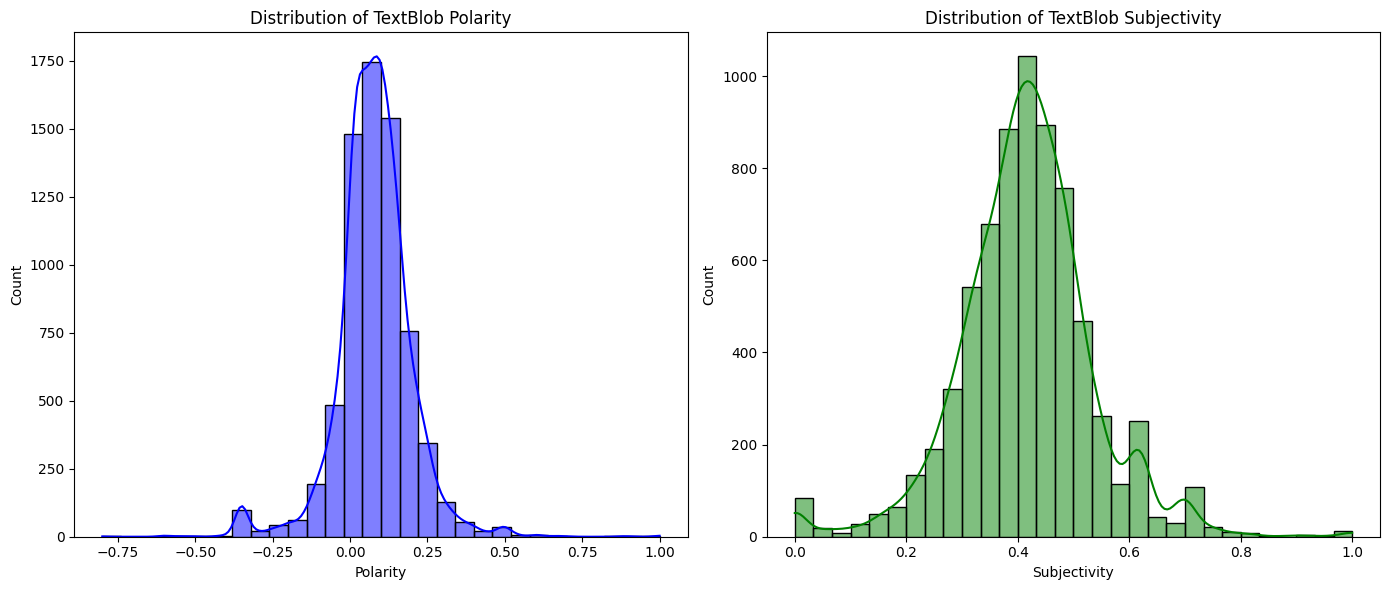

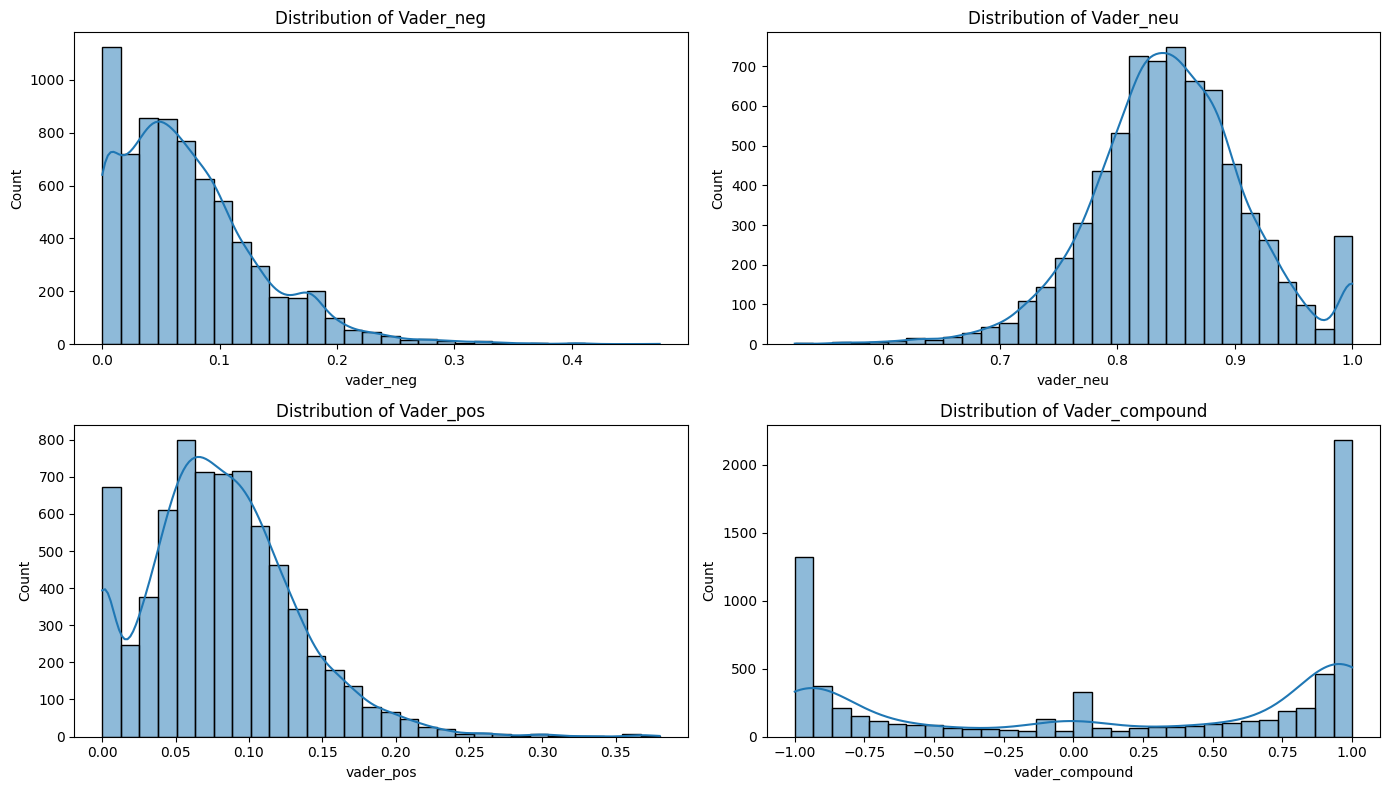

In [53]:
# 1. Distribution of TextBlob Sentiments
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['textblob_polarity'], kde=True, bins=30, color='blue')
plt.title('Distribution of TextBlob Polarity')
plt.xlabel('Polarity')

plt.subplot(1, 2, 2)
sns.histplot(df['textblob_subjectivity'], kde=True, bins=30, color='green')
plt.title('Distribution of TextBlob Subjectivity')
plt.xlabel('Subjectivity')

plt.tight_layout()
plt.show()

# 2. VADER Sentiment Distribution
plt.figure(figsize=(14, 8))
for i, col in enumerate(['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# # 3. Scatterplot of Polarity vs. Subjectivity
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='textblob_polarity', y='textblob_subjectivity', hue='label', palette='Set1')
# plt.title('Polarity vs. Subjectivity (Colored by Label)')
# plt.xlabel('TextBlob Polarity')
# plt.ylabel('TextBlob Subjectivity')
# plt.legend(title='Label (True/False)')
# plt.show()

# # 4. Heatmap of Correlation
# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Heatmap of Correlation')
# plt.show()

# # 5. Sentiment and Label Comparison
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 3, 1)
# sns.boxplot(data=df, x='label', y='textblob_polarity', palette='Set2')
# plt.title('TextBlob Polarity by Label')
# plt.xlabel('Label (True/False)')

# plt.subplot(1, 3, 2)
# sns.boxplot(data=df, x='label', y='textblob_subjectivity', palette='Set2')
# plt.title('TextBlob Subjectivity by Label')
# plt.xlabel('Label (True/False)')

# plt.subplot(1, 3, 3)
# sns.boxplot(data=df, x='label', y='vader_compound', palette='Set2')
# plt.title('VADER Compound by Label')
# plt.xlabel('Label (True/False)')

# plt.tight_layout()
# plt.show()

# # 6. Leaning vs. Label Comparison
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='leaning', y='vader_compound', hue='label', palette='Set1')
# plt.title('Leaning vs. VADER Compound (Colored by Label)')
# plt.xlabel('Leaning')
# plt.ylabel('VADER Compound')
# plt.show()

# 7. Stacked Bar Chart of Label by Leaning Categories
# df['leaning_category'] = pd.cut(df['leaning'], bins=[-1, -0.33, 0.33, 1], labels=['Left', 'Center', 'Right'])
# label_counts = df.groupby(['leaning_category', 'label']).size().unstack()
# label_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])
# plt.title('Label Proportions by Leaning Category')
# plt.xlabel('Leaning Category')
# plt.ylabel('Count')
# plt.legend(title='Label (True/False)')
# plt.show()

# 8. Leaning vs. Sentiment
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# sns.scatterplot(data=df, x='leaning', y='textblob_polarity', alpha=0.6)
# plt.title('Leaning vs. TextBlob Polarity')
# plt.xlabel('Leaning')
# plt.ylabel('Polarity')

# plt.subplot(1, 2, 2)
# sns.scatterplot(data=df, x='leaning', y='vader_compound', alpha=0.6)
# plt.title('Leaning vs. VADER Compound')
# plt.xlabel('Leaning')
# plt.ylabel('VADER Compound')

# plt.tight_layout()
# plt.show()

# # 9. Leaning Sentiment Polarity Density
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='textblob_polarity', hue='leaning_category', fill=True)
# plt.title('TextBlob Polarity Density by Leaning Category')
# plt.xlabel('Polarity')
# plt.ylabel('Density')
# plt.show()

# 10. True vs. Fake Leaning Comparison
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df, x='label', y='leaning', palette='Set2')
# plt.title('Leaning by Label')
# plt.xlabel('Label (True/False)')
# plt.ylabel('Leaning')
# plt.show()

# 11. 3D Scatterplot of Polarity, Subjectivity, and VADER Compound
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(df['textblob_polarity'], df['textblob_subjectivity'], df['vader_compound'], c=df['label'], cmap='Set1', alpha=0.6)
# ax.set_title('3D Scatterplot of Polarity, Subjectivity, and VADER Compound')
# ax.set_xlabel('TextBlob Polarity')
# ax.set_ylabel('TextBlob Subjectivity')
# ax.set_zlabel('VADER Compound')
# legend1 = ax.legend(*scatter.legend_elements(), title="Label (True/False)")
# ax.add_artist(legend1)
# plt.show()

# 12. Clustering with KMeans (PCA for visualization)
# features = df[['textblob_polarity', 'textblob_subjectivity', 'vader_compound', 'leaning']]
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# Apply PCA for 2D visualization
# pca = PCA(n_components=2)
# features_pca = pca.fit_transform(features_scaled)

# # Apply KMeans
# kmeans = KMeans(n_clusters=3, random_state=42)
# df['cluster'] = kmeans.fit_predict(features_scaled)

# # Plot clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=df['cluster'], palette='Set2')
# plt.title('KMeans Clustering (2D PCA Projection)')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.legend(title='Cluster')
# plt.show()

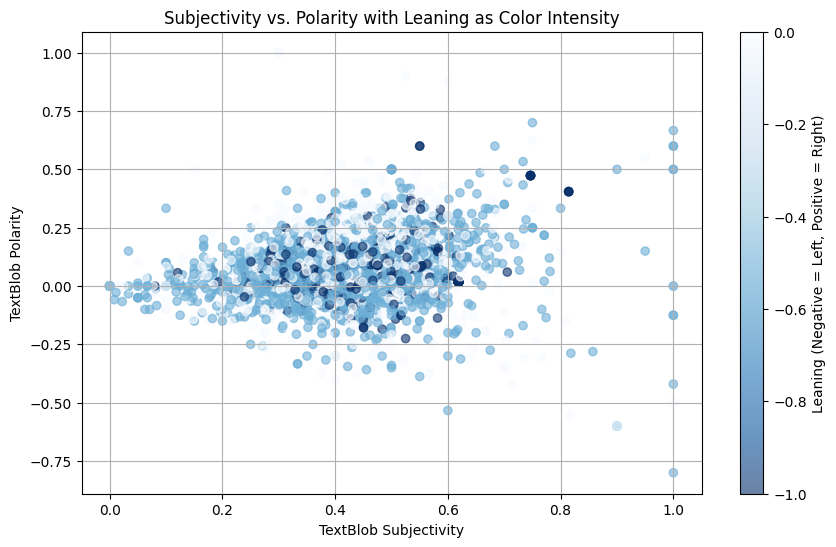

In [54]:
# Scatterplot of Subjectivity vs. Polarity with Leaning as Color Intensity

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['textblob_subjectivity'], df['textblob_polarity'], c=df['leaning'], cmap='Blues_r', alpha=0.6)
plt.title('Subjectivity vs. Polarity with Leaning as Color Intensity')
plt.xlabel('TextBlob Subjectivity')
plt.ylabel('TextBlob Polarity')
colorbar = plt.colorbar(scatter)
colorbar.set_label('Leaning (Negative = Left, Positive = Right)')
plt.grid(True)
plt.show()


/tmp/ipykernel_1022553/1263767626.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leaning_bin', y='textblob_subjectivity', palette='Set2')


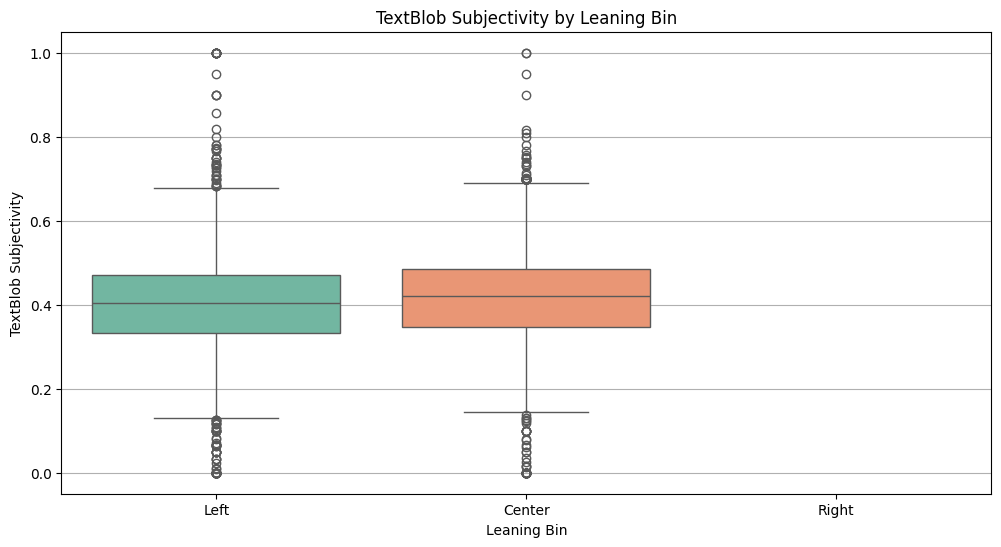

/tmp/ipykernel_1022553/1263767626.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='leaning_bin', y='textblob_polarity', palette='Set2')


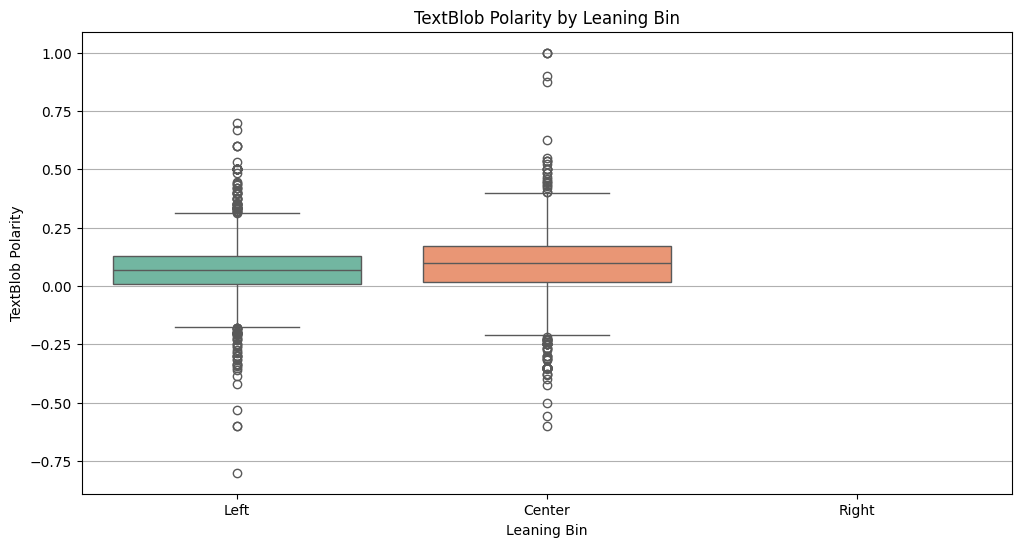

In [55]:
# Creating boxplots for Subjectivity and Polarity against Leaning
# For visualization purposes, I will create bins for the leaning scores and use those bins to create the boxplots.

# Create bins for 'leaning' (e.g., Left, Center, Right)
df['leaning_bin'] = pd.cut(df['leaning'], bins=[-1, -0.33, 0.33, 1], labels=['Left', 'Center', 'Right'])

# Boxplot for Subjectivity by Leaning Bin
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='leaning_bin', y='textblob_subjectivity', palette='Set2')
plt.title('TextBlob Subjectivity by Leaning Bin')
plt.xlabel('Leaning Bin')
plt.ylabel('TextBlob Subjectivity')
plt.grid(axis='y')
plt.show()

# Boxplot for Polarity by Leaning Bin
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='leaning_bin', y='textblob_polarity', palette='Set2')
plt.title('TextBlob Polarity by Leaning Bin')
plt.xlabel('Leaning Bin')
plt.ylabel('TextBlob Polarity')
plt.grid(axis='y')
plt.show()



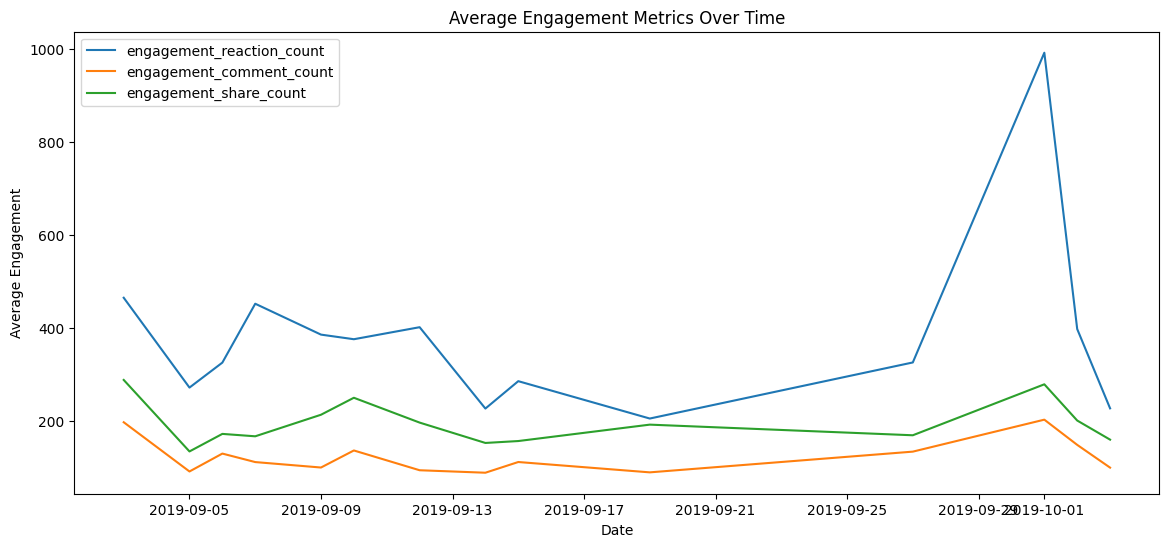

In [33]:
## MORE PLOTS (using engagement for example)
# Convert 'published_at' to datetime for time series analysis

# df['published_at'] = pd.to_datetime(df['published_at'])
# Convert 'published_at' to datetime, handling ISO 8601 format
df['published_at'] = pd.to_datetime(df['published_at'], format='ISO8601', errors='coerce')

# Check for rows that could not be converted
invalid_dates = df[df['published_at'].isna()]
if not invalid_dates.empty:
    print(f"Found {len(invalid_dates)} invalid date rows. You may want to inspect or clean these.")
    print(invalid_dates[['published_at']])

# Group by date and calculate average engagement metrics
engagement_time_series = df.groupby(df['published_at'].dt.date)[
    ['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']
].mean()

# Plot the time series
plt.figure(figsize=(14, 6))
for col in engagement_time_series.columns:
    plt.plot(engagement_time_series.index, engagement_time_series[col], label=col)

plt.title('Average Engagement Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Average Engagement')
plt.legend()
plt.show()


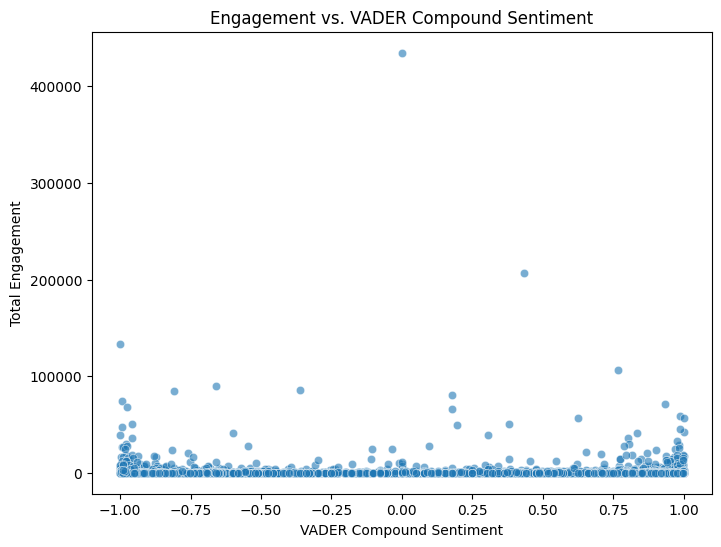

In [34]:
# Scatter plot of total engagement vs. VADER compound sentiment
df['total_engagement'] = (
    df['engagement_reaction_count'] + 
    df['engagement_comment_count'] + 
    df['engagement_share_count']
)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='vader_compound', y='total_engagement', alpha=0.6)
plt.title('Engagement vs. VADER Compound Sentiment')
plt.xlabel('VADER Compound Sentiment')
plt.ylabel('Total Engagement')
plt.show()


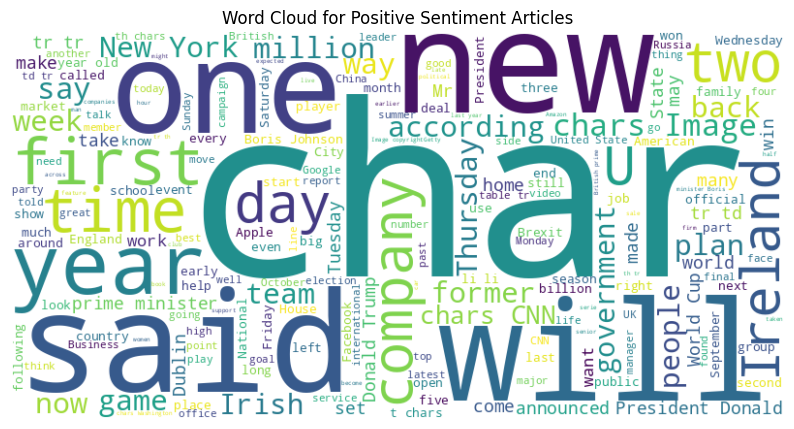

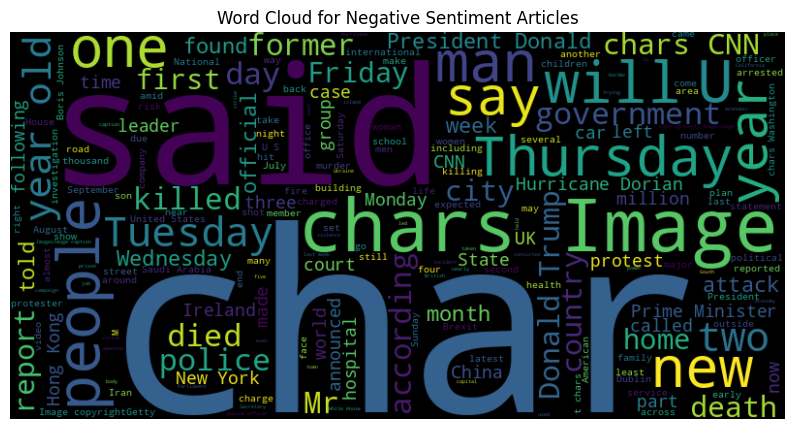

In [38]:
from wordcloud import WordCloud

# Generate word clouds for articles with extreme sentiment
positive_content = " ".join(df[df['vader_compound'] > 0.5]['content'].dropna())
negative_content = " ".join(df[df['vader_compound'] < -0.5]['content'].dropna())

# Positive sentiment word cloud
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_content)
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Articles')
plt.show()

# Negative sentiment word cloud
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_content)
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment Articles')
plt.show()


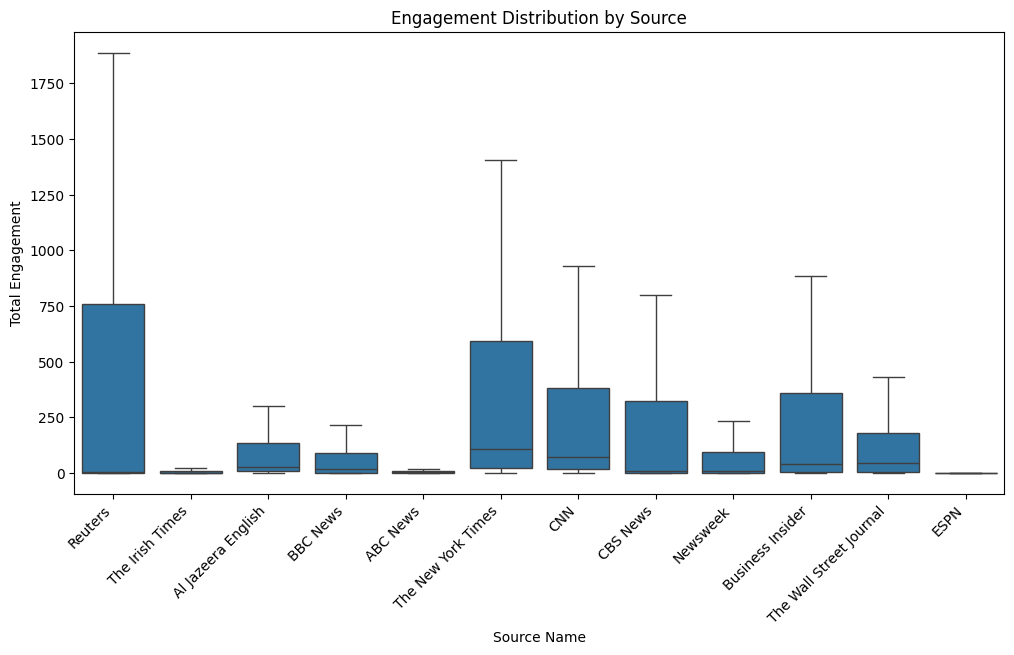

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='source_name', y='total_engagement', showfliers=False)
plt.title('Engagement Distribution by Source')
plt.xlabel('Source Name')
plt.ylabel('Total Engagement')
plt.xticks(rotation=45, ha='right')
plt.show()


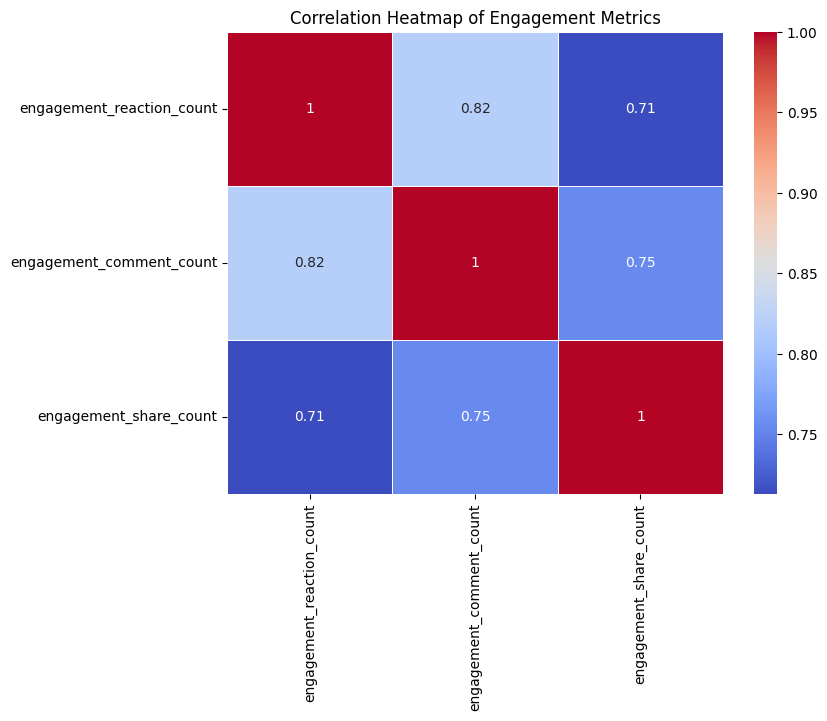

In [40]:
# Select engagement columns
engagement_metrics = df[
    ['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']
]

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(engagement_metrics.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Engagement Metrics')
plt.show()

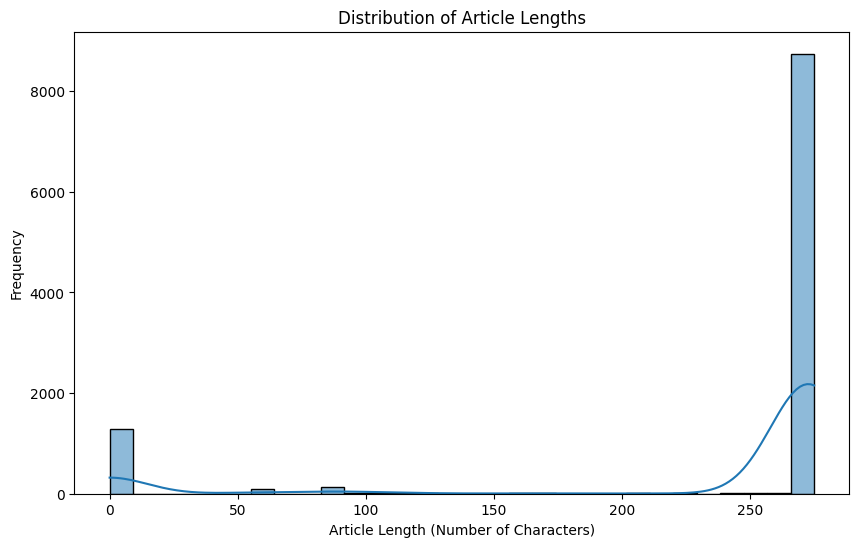

In [41]:
# Calculate article length
df['content_length'] = df['content'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Plot the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['content_length'], bins=30, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Article Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()


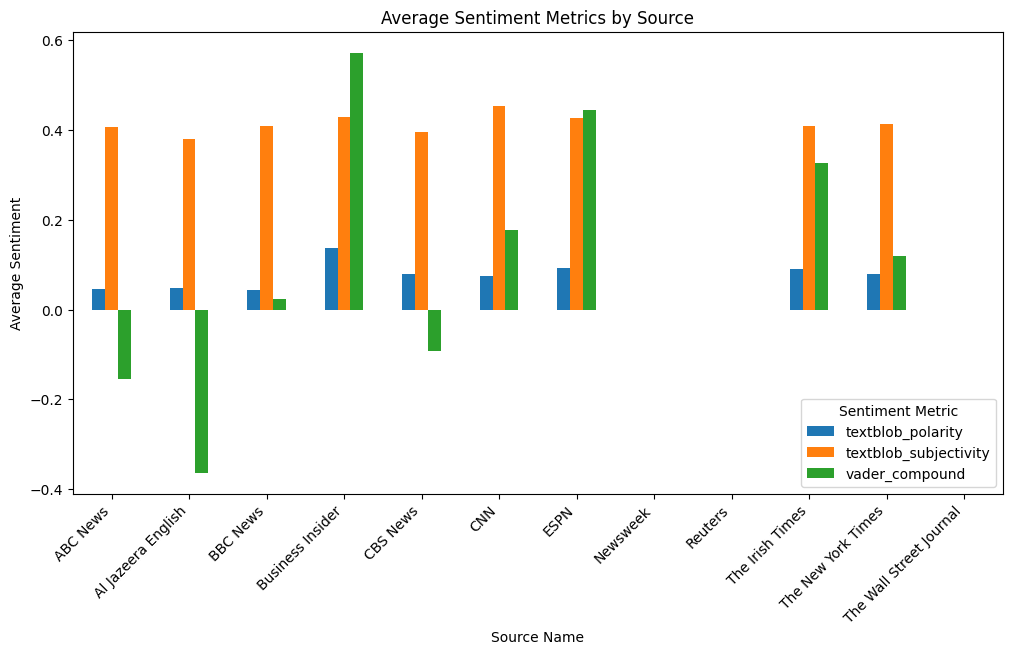

In [42]:
# Calculate average sentiment per source
avg_sentiment = df.groupby('source_name')[['textblob_polarity', 'textblob_subjectivity', 'vader_compound']].mean()

# Plot average sentiment by source
avg_sentiment.plot(kind='bar', figsize=(12, 6))
plt.title('Average Sentiment Metrics by Source')
plt.xlabel('Source Name')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment Metric')
plt.show()


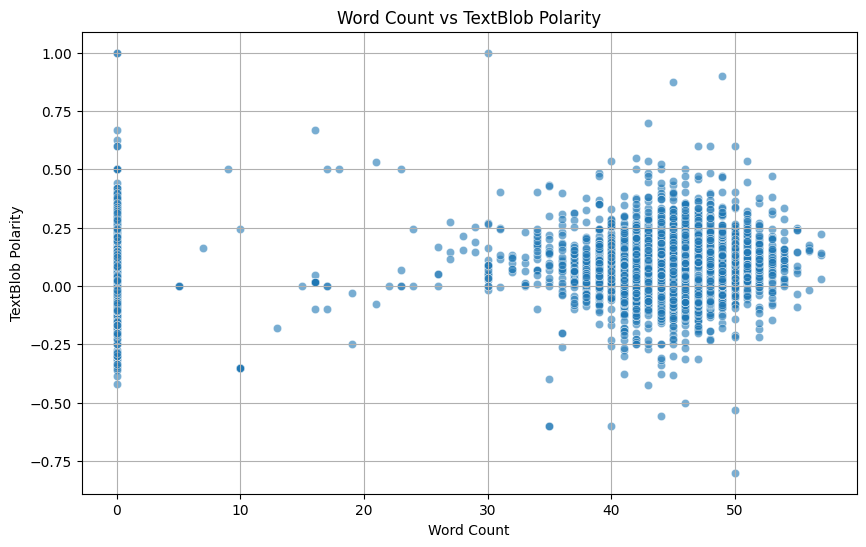

In [43]:
# Calculate word count
df['word_count'] = df['content'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Scatterplot of word count vs sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='word_count', y='textblob_polarity', alpha=0.6)
plt.title('Word Count vs TextBlob Polarity')
plt.xlabel('Word Count')
plt.ylabel('TextBlob Polarity')
plt.grid()
plt.show()

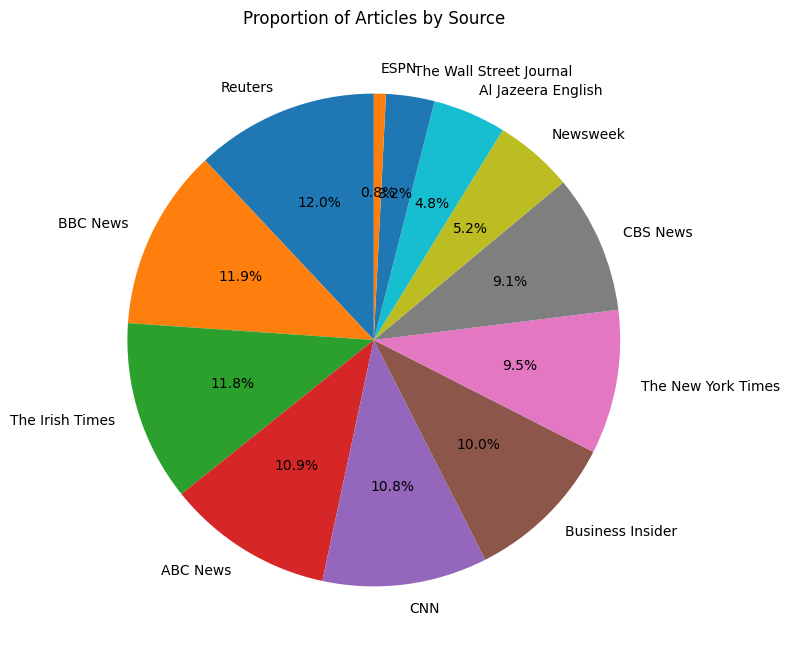

In [44]:
# Count articles per source
source_counts = df['source_name'].value_counts()

# Plot as a pie chart
plt.figure(figsize=(10, 6))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.title('Proportion of Articles by Source')
plt.ylabel('')
plt.show()

In [ ]:
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler